In [2]:
from segmentation.findOptimalRotation import find_optimal_rotation
from segmentFunction import segment_dss_page
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from data_management.augmentation.commonAug import whitespaceRemover, imgResizer
from skimage.transform import rotate
from skimage.morphology import reconstruction, area_opening, skeletonize, medial_axis, area_closing


def rotate_and_find_number_of_peaks(img):
    blurredImg = img.copy()
    # apply mutliple iterations of dilation and erosion with a rectangular kernel
    # to try and remove vertical lines, and thicken horizontal lines
    for i in range(8):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,3))
        blurredImg = cv2.dilate(blurredImg, kernel, iterations=1)

        blurredImg = cv2.erode(blurredImg, kernel, iterations=1)
    
    # make the image smaller (makes finding the rotations much faster)
    blurredImg = imgResizer(blurredImg, desired_size = 500)

    # soften the edges
    #kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    #blurryboi = cv2.erode(blurryboi, kernel, iterations=1)
    blurredImg = cv2.GaussianBlur(blurredImg, (9, 9), 0)
    
    rot_image, rot_degree, num_peaks, rot_line_peaks = find_optimal_rotation(blurredImg, "hi", lookahead=15, runmode=0)

    return blurredImg, rot_degree, rot_image, num_peaks



def getSkewAngle(gray):
    # Prep image, copy, convert to gray scale, blur, and threshold
    blur = cv2.GaussianBlur(gray, (25, 25), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilation to merge letters into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=4)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)

    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle

    # in case the angle is massive, its because the image is much taller than it is wide
    # this -=90 is to stop it from trying to turn the image sideways
    if angle > 15: 
        angle -= 90
        #return 0
    return int(-1.0 * angle)

In [3]:
hebrewCharacters = {
    "Alef" : '\u05d0',
    "Ayin" : '\u05e2', # fix
    "Bet" : '\u05d1',
    "Dalet" : '\u05d3',
    "Gimel" : '\u05d2',
    "He" : '\u05d4',
    "Het" : '\u05d7',
    "Kaf" : '\u05db',
    "Kaf-final" : '\u05da',
    "Lamed" : '\u05dc',
    "Mem" : '\u05dd',  # should be "mem-final" but leave it for now
    "Mem-medial" : '\u05de', 
    "Nun-final" : '\u05df',
    "Nun-medial" : '\u05e0',
    "Pe" : '\u05e4',
    "Pe-final" : '\u05e3',
    "Qof" : '\u05e7',
    "Resh" : '\u05e8',
    "Samekh" : '\u05e1',
    "Shin" : '\u05e9',
    "Taw" : '\u05ea',
    "Tet" : '\u05d8',
    "Tsadi-final" : '\u05e5',
    "Tsadi-medial" : '\u05e6',
    "Waw" : '\u05d5', # fix
    "Yod" : '\u05d9',
    "Zayin" :'\u05d6' 
}

In [4]:
from sklearn.cluster import KMeans
from sklearn import preprocessing as pre
from sklearn.metrics import silhouette_score
from sklearn import metrics


def clusterBoundingBoxes(img, BBs, Centers, num_peaks, k_range, plot=False):
    #X_centers = Centers[:,0]
    Y_centers = Centers[:,1]

    Y_in = np.array(Y_centers).reshape(-1, 1)
    scaler = pre.MinMaxScaler()
    Y_in = scaler.fit_transform(Y_in)

    #scaler2 = 10 / (img.shape[0] / img.shape[1])
    scaler2 = 1
    Y_in *= scaler2 # scale the y coords here

    k = findOptimalK(Y_in, start=num_peaks, end=num_peaks+k_range)
    #print("optimal K", k)

    model = KMeans(n_clusters=k)
    preds = model.fit_predict(Y_in)

    centers = scaler.inverse_transform(model.cluster_centers_   / scaler2 )
    centers = [int(cent[0]) for cent in centers]
    sorted_centers, sorted_cluster_datapoints = groupAndSortBBClusters(k, BBs, preds, centers)

    # If you want to see the plots (they do look nice)
    if plot:
        COLOURS = np.random.randint(0, 255, [k, 3])
        imWidth = img.shape[1]
        drawing_img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)

        # draw each bounding box, and the center point that was used in clustering
        for idx, (cluster_position, cluster_BBs) in enumerate(zip(sorted_centers, sorted_cluster_datapoints)):
            colour = COLOURS[idx]
            colour = (int(colour[0]), int(colour[1]), int(colour[2]))
            cv2.line(drawing_img, (0, cluster_position), (imWidth, cluster_position), color = colour, thickness=10)

            for x1,y1,x2,y2 in (cluster_BBs):
                colour = (int(colour[0]), int(colour[1]), int(colour[2]))
                cv2.rectangle(drawing_img, (x1,y1), (x2,y2), color = colour, thickness=2)

        for cnt in Centers:  cv2.circle(drawing_img, (cnt[0], cnt[1]), 5, (255,0,0), 5)

        plt.imshow(drawing_img)
        plt.show()

    
    
    return sorted_cluster_datapoints



def findOptimalK(data, start=2, end=20):
    inertia = []
    silhouette_scores = []

    for k in range(start,end):
        # make and fit the K-means clustering
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        
        # calculate inertia
        MSD = kmeans.inertia_
        RMSD = np.sqrt(MSD)
        inertia.append(RMSD)

        # calculate silhouette score
        sil_score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(sil_score)

    # the best value for K is the one with the highest silhouette score
    optimal = silhouette_scores.index(max(silhouette_scores))  +  start  # 'index' method starts at 0
    return optimal


def plotSegmentedBBs(img, BBs):
    for (x1,y1,x2,y2) in BBs:
        img = cv2.rectangle(img, (x1,y1), (x2,y2), color = (0,0,0), thickness=2)
    return img


def calculateLowCenters(BBs, Centers):
    LowCenters = []
    for ((x1,y1,x2,y2), old_center) in zip(BBs, Centers):
        h = y2 - y1
        w = x2 - x1

        if h/w > 1.1:
            new_center = [int((x2+x1)/2),   int(y2 - w/2)]
            LowCenters.append(new_center)
        else:
            LowCenters.append(old_center)

    return LowCenters


def sort_BB_cluster_rows(k, BBs, preds, centers):
    cluster_datapoints = [[] for i in range(k)]
    
    for idx, bb in enumerate(BBs):
        label = preds[idx]
        cluster_datapoints[label].append(bb)
    #print(cluster_datapoints)
    #print(centers)

    sorted_centers, sorted_cluster_datapoints = zip(*sorted(zip(centers, cluster_datapoints)))
    #print(sorted_centers)


    return sorted_centers, sorted_cluster_datapoints

# sorts the bounding box
def sortBBLines(BB_groups, right_to_left = True):
    BB_groups_sorted = []
    for group in BB_groups:
        group_srtd = sorted(group, key=lambda x: x[0], reverse=True)
        BB_groups_sorted.append(group_srtd)
    return BB_groups_sorted

In [6]:
from segmentation.findOptimalRotation import find_optimal_rotation
from segmentFunction import segment_dss_page
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from data_management.augmentation.commonAug import whitespaceRemover, imgResizer
from skimage.transform import rotate
from segmentFunction import segment_dss_page

sourceFolder = "image-data"
binaryFiles = []
for filename in os.listdir(sourceFolder):
    if 'binarized' in filename: binaryFiles.append(filename)


BIGSORTEDLIST = []
BIGIMAGESLIST = []

for filename in binaryFiles:
    img_path = os.path.join(sourceFolder, filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) #Read the img
    img = whitespaceRemover(img=img, padding=50)
    #img = cv2.bitwise_not(img)

    blurryboi, best_rotation_angle, rot_image, num_peaks = find_number_of_lines(img)
    #print("number of peaks", num_peaks)

    #best_rotation_angle = getSkewAngle(img)

    img_to_plot = img.copy()
    
    # this function rotates the original image, with the angle being defined in the counterclockwise
    rotated_image = rotate(img, best_rotation_angle, resize=True, cval=1, clip=False, mode ='constant')
    rotated_image = rotated_image * 255
    rotated_image = rotated_image.astype(np.uint8)

    #plt.imshow(rotated_image)
    #plt.show()
    #print(rotated_image)
    BBs, Centers = segment_dss_page(rotated_image)
    LowCenters = calculateLowCenters(BBs, Centers)
    Centers = np.array(Centers)
    LowCenters=np.array(LowCenters)

    k_range = 3
    BB_groups = clusterBoundingBoxes(rotated_image, BBs, LowCenters, num_peaks, k_range, plot=False)

    BB_groups_sorted = sortBBLines(BB_groups, right_to_left=False) # change to false if reading each line from left to right

    BIGSORTEDLIST.append(BB_groups_sorted)
    BIGIMAGESLIST.append(rotated_image)



In [7]:
from classification_models.CNN_models import CharacterCNN, LeNet5, DanNet1
import torch

def getClassifierModel(path_to_saved_CNN):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = LeNet5()#.to(device)\
    model.load_state_dict(torch.load(path_to_saved_CNN, map_location=device))  # map_location makes it possible to load the model trained on a gpu, onto a cpu (for eval)
    model.to(device)

    model.eval()

    return model

In [10]:
import torchvision.transforms as transforms
from data_management.augmentation.commonAug import imgResizer

character_names = list(hebrewCharacters.keys())


path_to_classifier = "classification_models/model_L5.pth"
model = getClassifierModel(path_to_classifier)




def classifyLetters(img, BB_groups_sorted, model, character_names):
    transform = transforms.ToTensor()

    classified_text = [] # list of strings, one string of letters per row in the image
    for row in BIGSORTEDLIST[im_idx]:
        row_letters = ""
        for bb in row: # for letter BB in this row
            # crop out the letter and resize it
            x1,y1,x2,y2 = bb
            #print(bb)
            letterIM = image[y1:y2, x1:x2] 
            letterIM = imgResizer(letterIM, desired_size=32)

            tensor = torch.unsqueeze(transform(letterIM), 0) # convert letter img to tensor (1,1,32,32)

            output = model.forward(tensor)                   # run classifier
            predicted_class = torch.argmax(output, 1).item() # get the classifer result
            letter_name = character_names[predicted_class]   # find the class name
            hebrew_letter = hebrewCharacters[letter_name]    # get the ascii hebrew character
            row_letters += hebrew_letter                     # add new letter to the row

        classified_text.append(row_letters)
    return classified_text



#############

for im_idx in range(len(BIGIMAGESLIST)):
    #im_idx = i
    image = BIGIMAGESLIST[im_idx]
    BB_groups_sorted = BIGSORTEDLIST[im_idx]
    image_filename = binaryFiles[im_idx]

    classified_text = classifyLetters(img, BB_groups_sorted, model)

    writeToDocument(classified_text, "Results/"+image_filename+".docx")



#plt.imshow(letterIM)
#plt.show()
# Define a transform to convert the image to tensor


# Convert the image to PyTorch tensor


In [ ]:
image.shape

(2441, 3321)

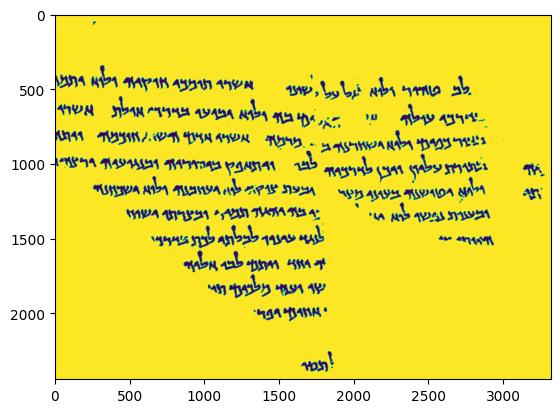

In [ ]:
plt.imshow(image)

In [8]:
from docx import Document
from docx.enum.text import WD_ALIGN_PARAGRAPH, WD_LINE_SPACING

def writeToDocument(classified_text, word_file_path):
    doc = Document()

    for row in classified_text:
        para = doc.add_paragraph(row)
        para.paragraph_format.alignment = WD_ALIGN_PARAGRAPH.RIGHT

    style = doc.styles['Normal']
    style.paragraph_format.line_spacing = 1

    doc.save(word_file_path)


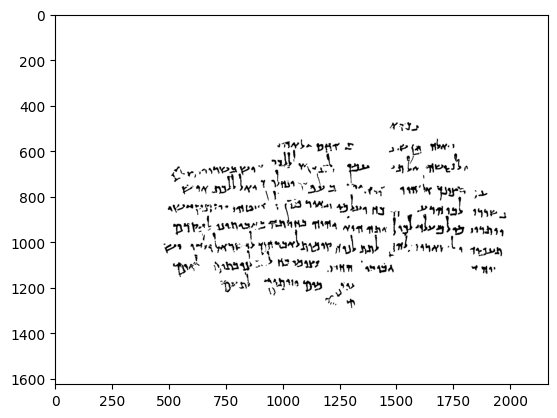

In [ ]:
sample_test_path = "Data/sample-test-2023/124-Fg004.pbm"
test_img = cv2.imread(sample_test_path)
plt.imshow(test_img)
